# Simple PINN for an elastic plate with a hole (TensorFlow)

## Represent geometry with collocation points

We represent the geometry by a set of collocation points 

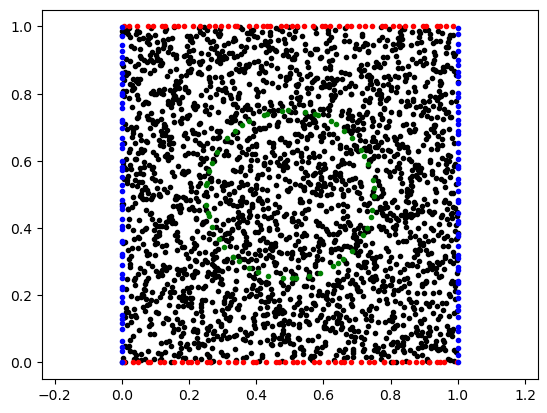

In [1]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from global_constants import L, R, B0, X0, Y0, EPS0, MU, LBD


# Compute collocation points
N = 50
domain = L * qmc.LatinHypercube(d=2).random(N**2)
mask = (((domain[:,0] - X0) ** 2 + (domain[:,1] - Y0) ** 2) > 0**2)
domain = domain[mask].astype(np.float32)

# Boundaries
xt = qmc.LatinHypercube(d=1).random(N)
top = L * np.hstack((xt, np.ones((N,1)))).astype(np.float32)
xb = qmc.LatinHypercube(d=1).random(N)
bottom = L * np.hstack((xb, np.zeros((N,1)))).astype(np.float32)
yl = qmc.LatinHypercube(d=1).random(N)
left = L * np.hstack((np.zeros((N,1)), yl)).astype(np.float32)
yr = qmc.LatinHypercube(d=1).random(N)
right = L * np.hstack((np.ones((N,1)), yr)).astype(np.float32)
phi = 2 * np.pi * qmc.LatinHypercube(d=1).random(N)
hole = np.hstack((R * np.cos(phi) + X0, R * np.sin(phi) + Y0 )).astype(np.float32)


# Visualize geometry (Dirichlet blue, Neumann red)
plt.plot(domain[:,0], domain[:,1], ".k")
plt.plot(top[:,0], top[:,1], ".r")
plt.plot(bottom[:,0], bottom[:,1], ".r")
plt.plot(left[:,0], left[:,1], ".b")
plt.plot(right[:,0], right[:,1], ".b")
plt.plot(hole[:,0], hole[:,1], ".g")
plt.axis("equal");


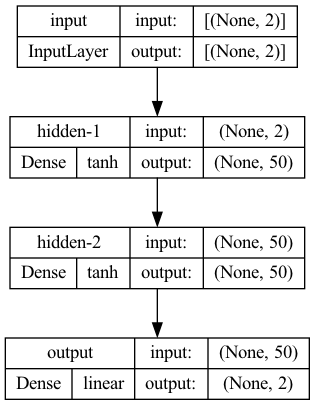

In [2]:
# build a dense multi-layer perceptron ANN to approximate the displacement field
model = keras.models.Sequential()
model.add(keras.Input(shape=(2,), name="input"))
model.add(keras.layers.Dense(50, activation="tanh", name="hidden-1"))
model.add(keras.layers.Dense(50, activation="tanh", name="hidden-2"))
model.add(keras.layers.Dense(2, activation="linear", name="output"))

keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)


In [3]:
@tf.function
def sigma(eps):
    N = eps.shape[0]
    I = tf.eye(2)
    return 2.0 * MU * eps + LBD * tf.einsum("...ii,...jk->...jk", eps, I)

@tf.function
def epsilon(x, y):
    x = tf.convert_to_tensor(x)
    y = tf.convert_to_tensor(y)

    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        g.watch(y)
        disp = model(tf.stack([x, y], axis=1))
        u = disp[:, 0]
        v = disp[:, 1]
    ux = g.gradient(u, x)
    uy = g.gradient(u, y)
    vx = g.gradient(v, x)
    vy = g.gradient(v, y)

    gradx = tf.stack([ux, vx], axis=1)
    grady = tf.stack([uy, vy], axis=1)
    grad = tf.stack([gradx, grady], axis=2)

    return 0.5 * (grad + tf.transpose(grad, perm=[0, 2, 1]))

@tf.function
def pde_residual(x,y):
    x = tf.convert_to_tensor(x)
    y = tf.convert_to_tensor(y)

    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        g.watch(y)
        stress = sigma(epsilon(x,y))
        s_xx = stress[:,0,0]
        s_xy = stress[:,0,1]
        s_yy = stress[:,1,1]

    residual_x = g.gradient(s_xx, x) + g.gradient(s_xy, y) - B0
    residual_y = g.gradient(s_xy, x) + g.gradient(s_yy, y)
    return residual_x, residual_y


In [4]:
def dirichlet_loss(pos, disp):
    disp_predict = model(pos)
    return (tf.reduce_mean(tf.square(disp_predict[:, 0] - disp[:, 0])) 
          + tf.reduce_mean(tf.square(disp_predict[:, 1] - disp[:, 1]))
    )

def pde_loss(pos):
    x = pos[:, 0]
    y = pos[:, 1]
    res_x, res_y = pde_residual(x, y)
    return tf.reduce_mean(tf.square(res_x)) + tf.reduce_mean(tf.square(res_y))

@tf.function
def loss(pos, _):
    # pde
    pde_error = pde_loss(pos)

    # left boundary
    displ = np.zeros_like(left)
    left_error = dirichlet_loss(left, displ)

    # right boundary
    dispr = np.zeros_like(right)
    dispr[:, 0] = EPS0 * L
    right_error = dirichlet_loss(right, dispr)

    # # top boundary
    # stresst = sigma(epsilon(top[:, 0], top[:, 1]))
    # top_error = tf.reduce_sum(tf.square(stresst[:, 1, 1])) + tf.reduce_sum(
    #     tf.square(stresst[:, 0, 1])
    # )
    # # bottom boundary
    # stressb = sigma(epsilon(bottom[:, 0], bottom[:, 1]))
    # bottom_error = tf.reduce_sum(tf.square(stressb[:, 1, 1])) + tf.reduce_sum(
    #     tf.square(stressb[:, 0, 1])
    # )
    # # hole boundary
    # stressh = sigma(epsilon(hole[:, 0], hole[:, 1]))
    # nx = -tf.convert_to_tensor((hole[:, 0] - X0) / R)
    # ny = -tf.convert_to_tensor((hole[:, 1] - Y0) / R)
    # normal = tf.stack([nx, ny], axis=1)
    # traction = tf.einsum("...ij,...j->...i", stressh, normal)
    # hole_error = tf.reduce_sum(tf.square(traction[:, 0])) + tf.reduce_sum(
    #     tf.square(traction[:, 1])
    # )

    return (
        left_error
        # + right_error
        # + top_error
        # + bottom_error
        # + hole_error
        + pde_error
    )


In [5]:
opt = keras.optimizers.RMSprop(learning_rate=0.001)
# opt = keras.optimizers.Nadam(learning_rate=0.001)
# opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=loss)

dummy = tf.zeros_like(domain)
history = model.fit(domain, dummy, epochs=500)


Epoch 1/500


2022-12-07 16:41:42.051563: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


79/79 [==============================] - 2s 1ms/step - loss: 0.0900
Epoch 2/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 3/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 4/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 5/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 6/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 7/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 8/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 9/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 10/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 11/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 12/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 13/500
79/79 [=============================

79/79 [==============================] - 0s 331us/step
tf.Tensor(0.94973385, shape=(), dtype=float32)
tf.Tensor(2.196897e-06, shape=(), dtype=float32)


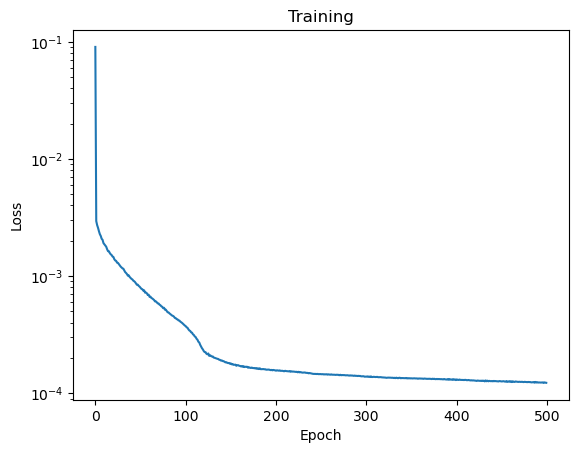

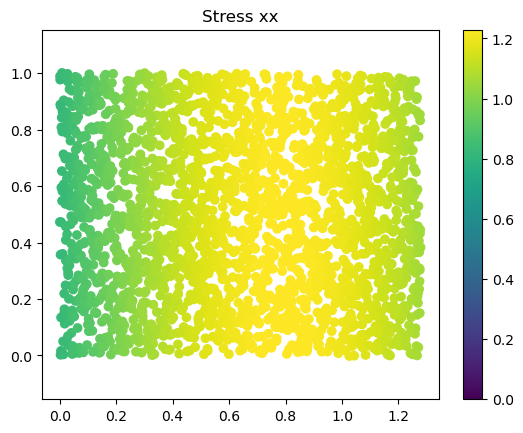

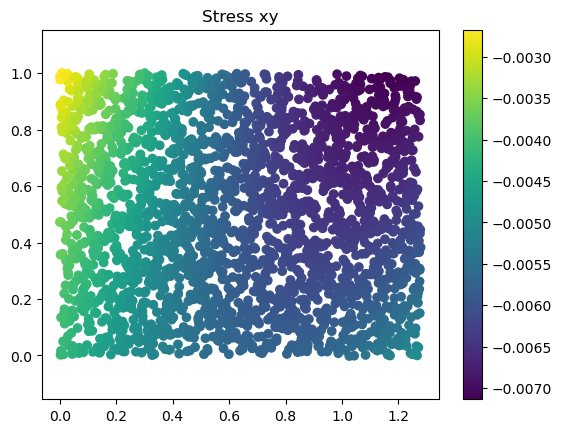

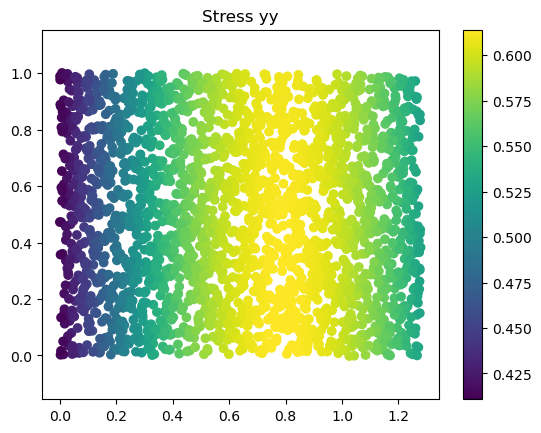

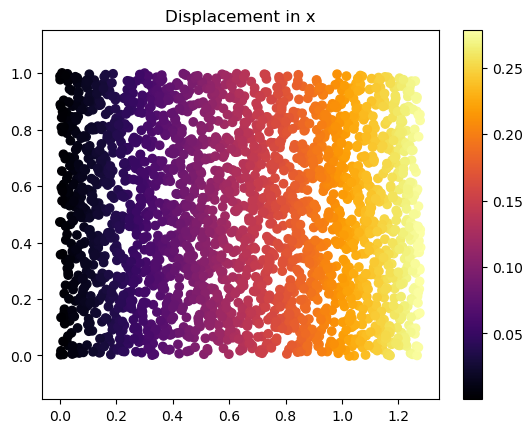

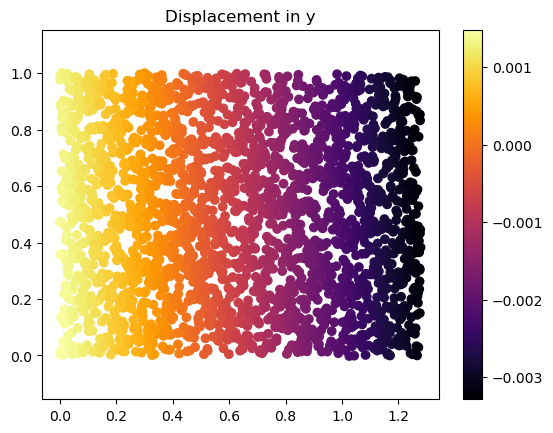

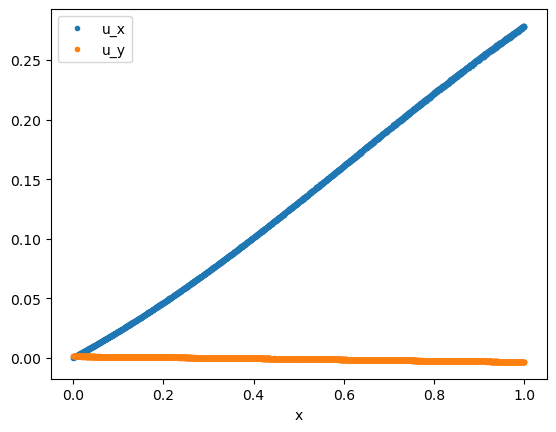

In [6]:
disp = model.predict(domain)
strain = epsilon(domain[:, 0], domain[:, 1])
stress = sigma(strain)

print(pde_loss(domain))
print(dirichlet_loss(left, np.zeros_like(left)))


plt.semilogy(history.history["loss"])
plt.title("Training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()


plt.scatter(domain[:, 0]+disp[:, 0], domain[:, 1] + disp[:, 1], c=stress[:, 0, 0], vmin=0)
plt.axis("equal")
plt.colorbar()
plt.title("Stress xx")
plt.show()

plt.scatter(domain[:, 0]+disp[:, 0], domain[:, 1] + disp[:, 1], c=stress[:, 0, 1])
plt.axis("equal")
plt.colorbar()
plt.title("Stress xy")
plt.show()

plt.scatter(domain[:, 0]+disp[:, 0], domain[:, 1] + disp[:, 1], c=stress[:, 1, 1])
plt.axis("equal")
plt.colorbar()
plt.title("Stress yy")
plt.show()

plt.scatter(domain[:, 0]+disp[:, 0], domain[:, 1] + disp[:, 1], c=disp[:, 0], cmap="inferno")
plt.axis("equal")
plt.colorbar()
plt.title("Displacement in x")
plt.show()

plt.scatter(domain[:, 0]+disp[:, 0], domain[:, 1] + disp[:, 1], c=disp[:, 1], cmap="inferno")
plt.axis("equal")
plt.colorbar()
plt.title("Displacement in y")
plt.show()

plt.plot(domain[:, 0], disp[:, 0], ".", label="u_x")
plt.plot(domain[:, 0], disp[:, 1], ".", label="u_y")
plt.xlabel("x")
plt.legend()
plt.show()

